In [1]:
!nvidia-smi

Wed Nov 22 09:16:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive')
!pwd

/content/drive/My Drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import random_split
torch.cuda.empty_cache()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# LOADING THE TRAINING SET

In [5]:
# load the data

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.image as mpimg

class SatelliteDataset(Dataset):
    def __init__(self, images_dir, ground_truth_dir, transform=None):
        self.images_dir = images_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = mpimg.imread(img_name)

        ground_truth_name = os.path.join(self.ground_truth_dir, self.images[idx])
        ground_truth = mpimg.imread(ground_truth_name)

        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)

        return image, ground_truth


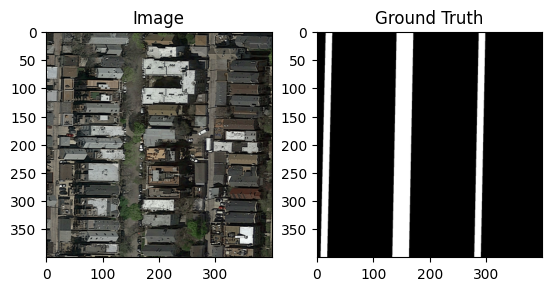

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Images to tensors
    # Add any other transforms you need here
])
dataset = SatelliteDataset("training/images", "training/groundtruth", transform=transform)

plt.subplot(1, 2, 1)

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(dataset[0][1].squeeze(), cmap='gray')

plt.title('Ground Truth')

plt.show()



# defining the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )

    def forward(self, x):
        return self.double_conv(x)

# Up Convolution block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
        )

    def forward(self, x):
        return self.up(x)

# Revised U-Net Model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        # Down
        self.dc1 = DoubleConv(n_channels, 64)
        self.dc2 = DoubleConv(64, 128)
        self.dc3 = DoubleConv(128, 256)
        self.dc4 = DoubleConv(256, 512)
        self.dc5 = DoubleConv(512, 1024)

        # Up
        self.up1 = UpConv(1024, 512)
        self.dc6 = DoubleConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.dc7 = DoubleConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.dc8 = DoubleConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.dc9 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.dc1(x)
        x2 = self.dc2(F.max_pool2d(x1, 2))
        x3 = self.dc3(F.max_pool2d(x2, 2))
        x4 = self.dc4(F.max_pool2d(x3, 2))
        x5 = self.dc5(F.max_pool2d(x4, 2))

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dc6(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dc7(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dc8(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dc9(x)

        logits = self.outc(x)
        return logits


# defining the loss function

In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice_coeff

bce_loss = nn.BCEWithLogitsLoss()
soft_dice_loss = SoftDiceLoss()

def calc_loss(pred, target):
    return bce_loss(pred, target) + soft_dice_loss(pred, target)


# Training the model

In [10]:
def train_model(model, optimizer, scheduler, num_epochs=10):
    best_loss = 1e10
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)

        train_epoch_loss = train_loss / train_samples
        print("Training Loss: {:.4f}".format(train_epoch_loss))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_samples += inputs.size(0)

        val_epoch_loss = val_loss / val_samples
        print("Validation Loss: {:.4f}".format(val_epoch_loss))

        # Check if this is the best model so far
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print("New best model saved with loss: {:.4f}".format(best_loss))

        # Print time elapsed for this epoch
        time_elapsed = time.time() - since
        print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Splitting dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
# Train the model
trained_model = train_model(model, optimizer, scheduler, num_epochs=70)


Epoch 0/69
----------
Training Loss: 1.2809
Validation Loss: 1.6098
New best model saved with loss: 1.6098
Epoch complete in 8m 28s
Epoch 1/69
----------
Training Loss: 1.1353
Validation Loss: 1.3528
New best model saved with loss: 1.3528
Epoch complete in 0m 57s
Epoch 2/69
----------
Training Loss: 1.0341
Validation Loss: 1.1545
New best model saved with loss: 1.1545
Epoch complete in 0m 56s
Epoch 3/69
----------
Training Loss: 0.9460
Validation Loss: 1.0765
New best model saved with loss: 1.0765
Epoch complete in 0m 56s
Epoch 4/69
----------
Training Loss: 0.8970
Validation Loss: 0.8960
New best model saved with loss: 0.8960
Epoch complete in 0m 56s
Epoch 5/69
----------
Training Loss: 0.8527
Validation Loss: 0.8420
New best model saved with loss: 0.8420
Epoch complete in 0m 56s
Epoch 6/69
----------
Training Loss: 0.7961
Validation Loss: 0.8145
New best model saved with loss: 0.8145
Epoch complete in 0m 57s
Epoch 7/69
----------
Training Loss: 0.7603
Validation Loss: 0.7182
New best

# visualize the results

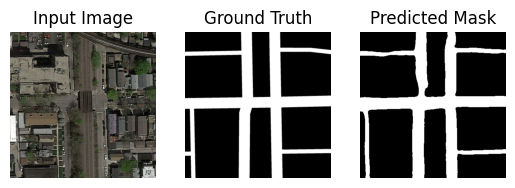

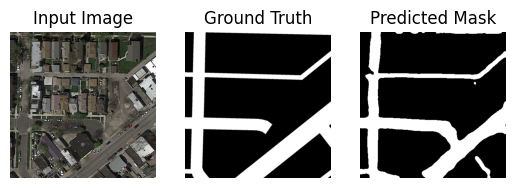

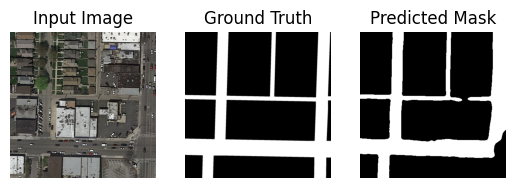

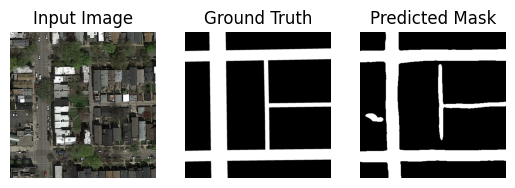

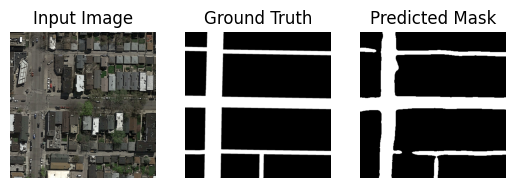

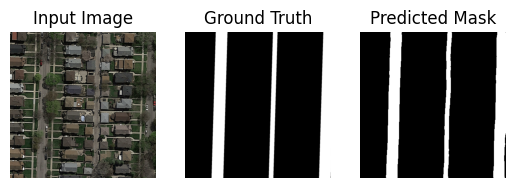

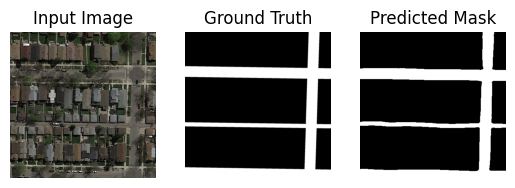

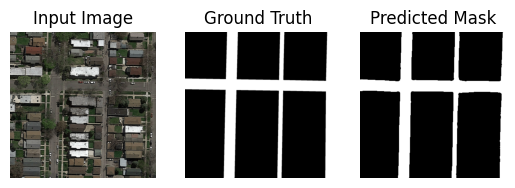

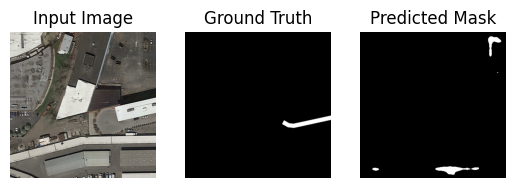

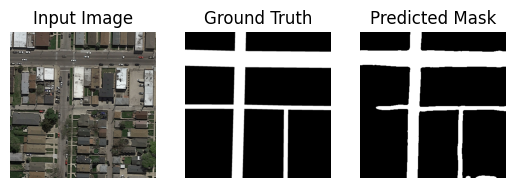

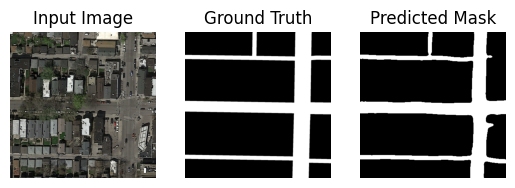

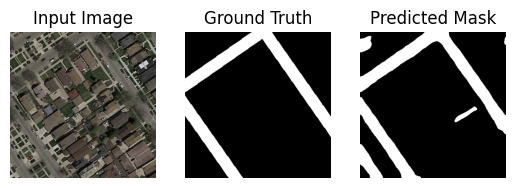

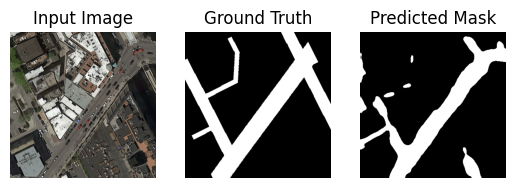

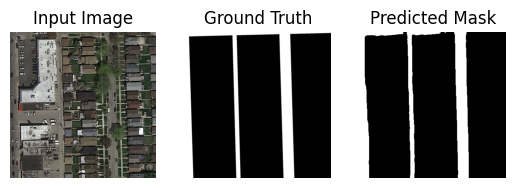

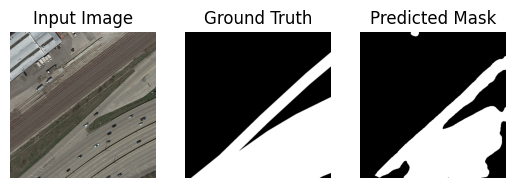

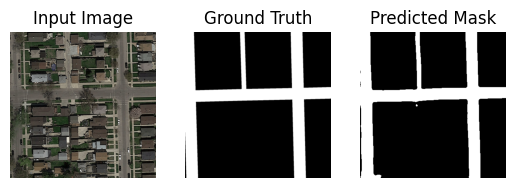

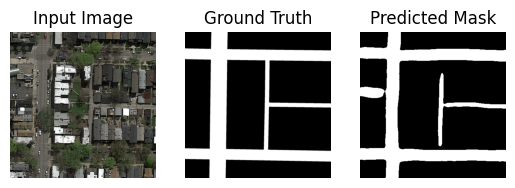

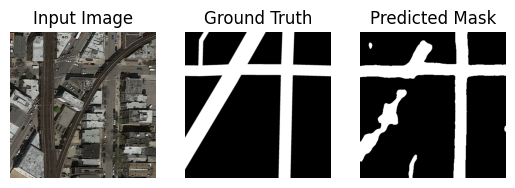

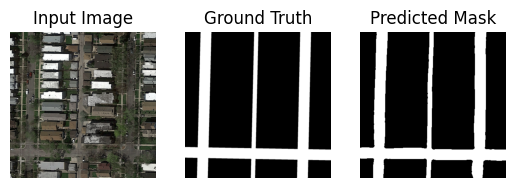

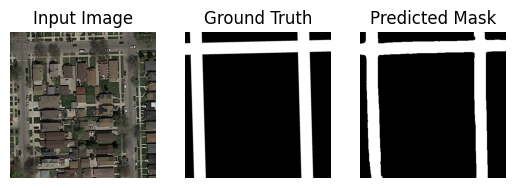

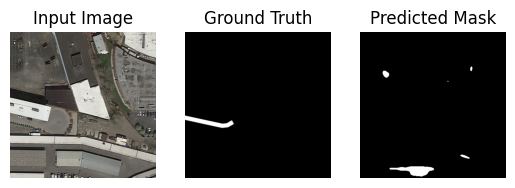

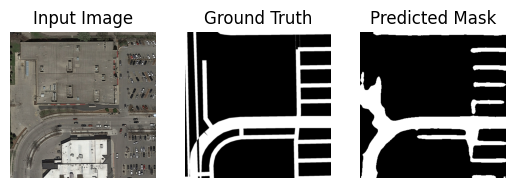

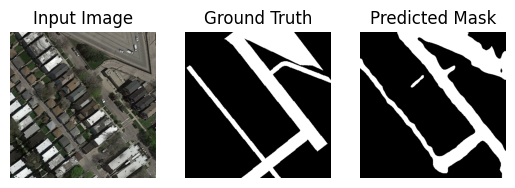

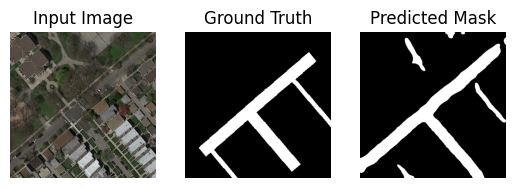

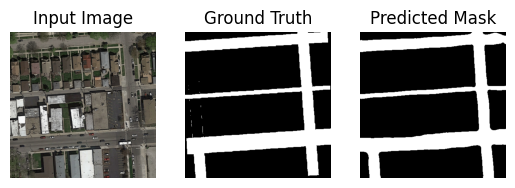

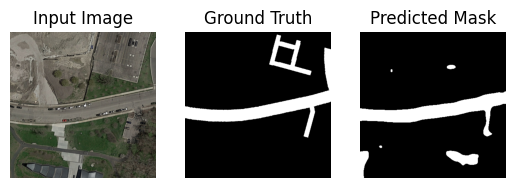

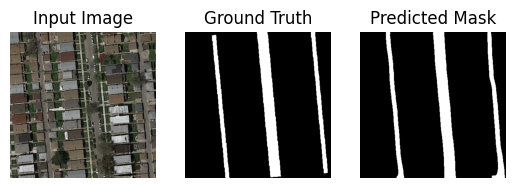

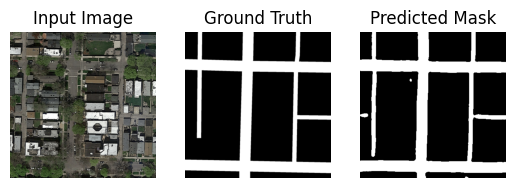

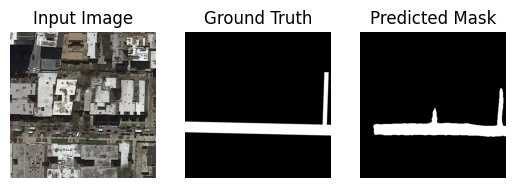

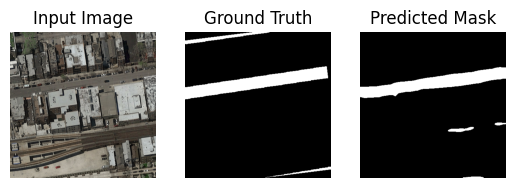

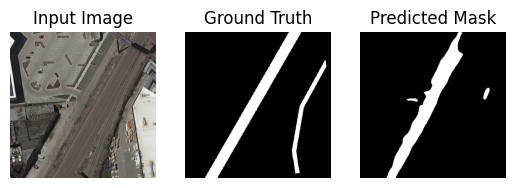

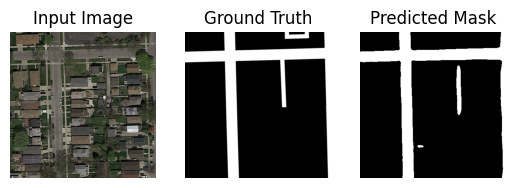

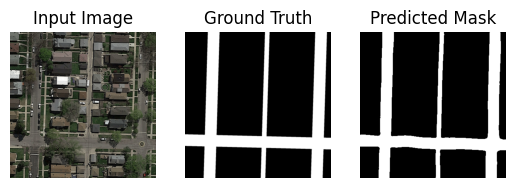

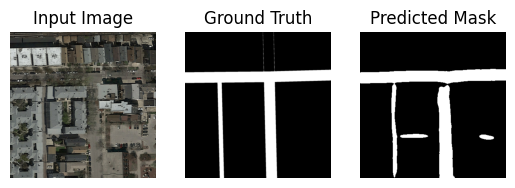

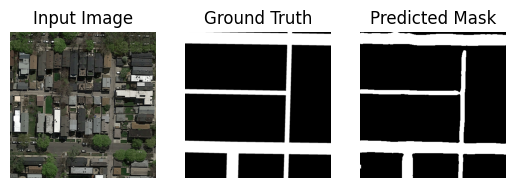

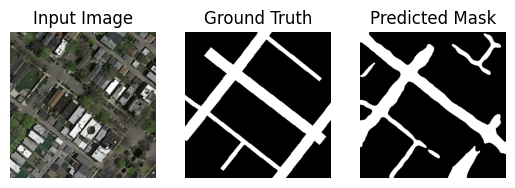

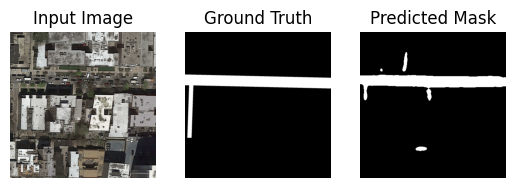

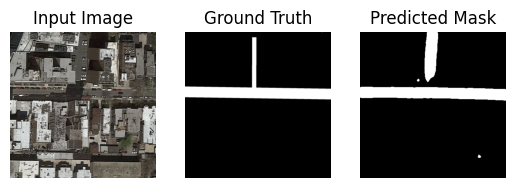

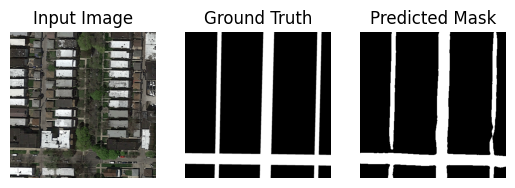

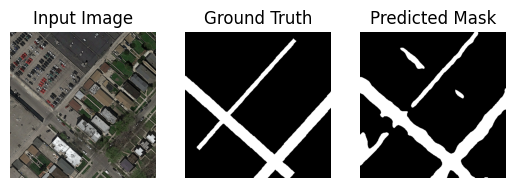

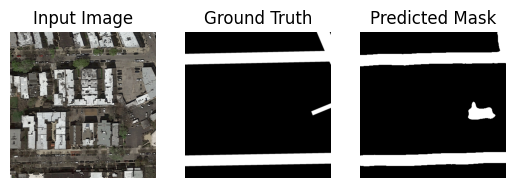

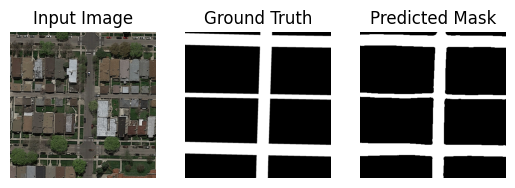

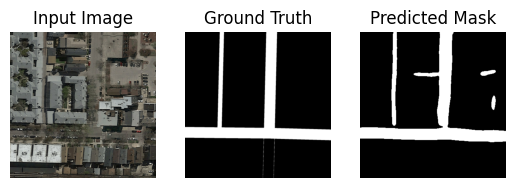

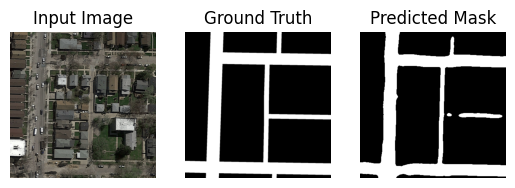

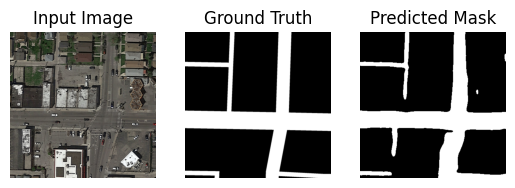

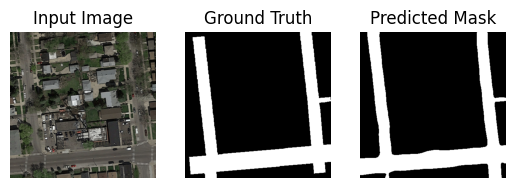

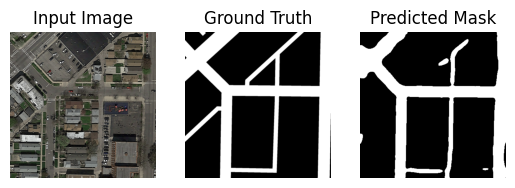

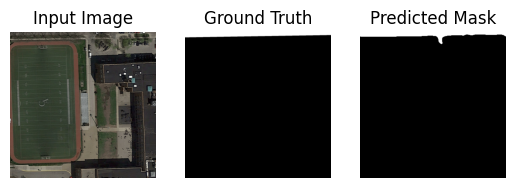

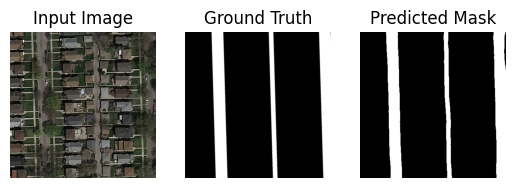

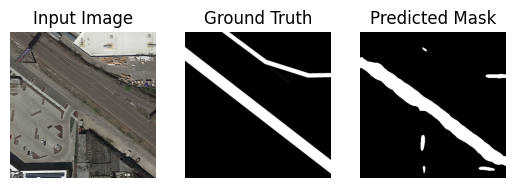

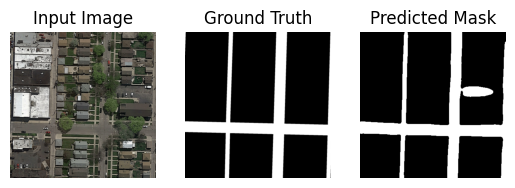

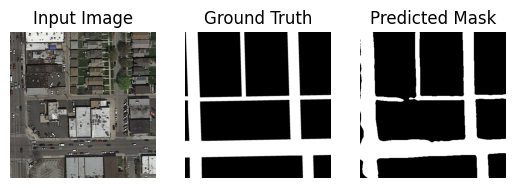

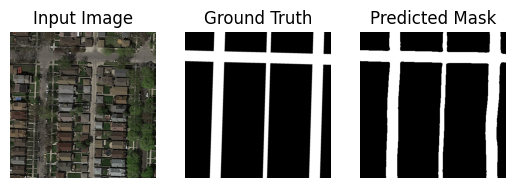

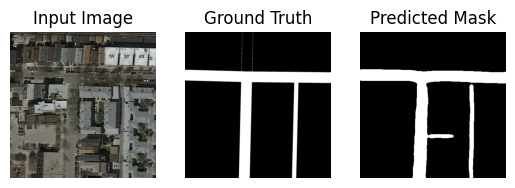

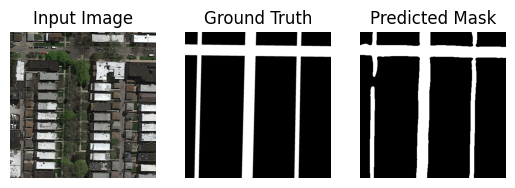

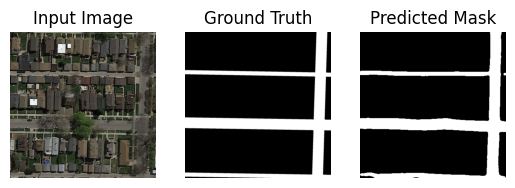

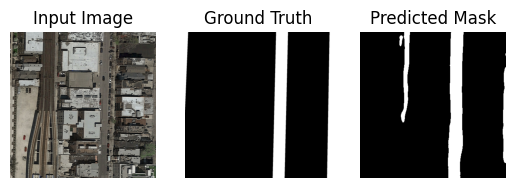

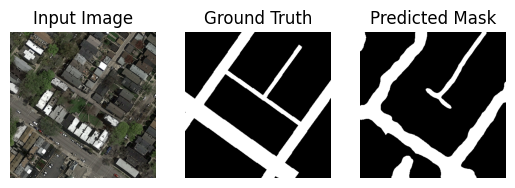

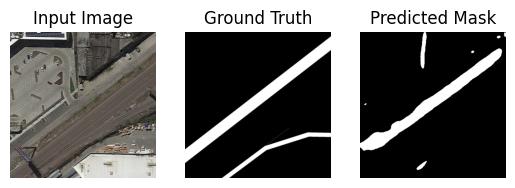

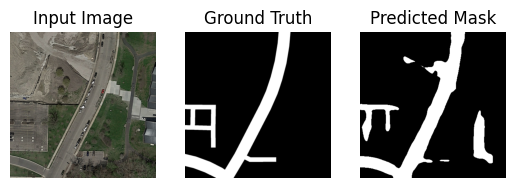

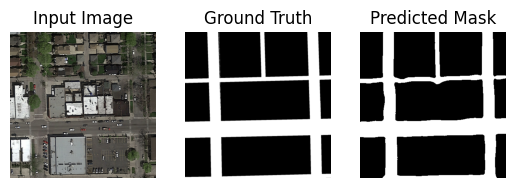

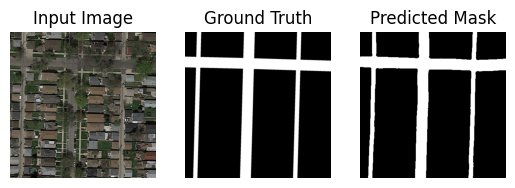

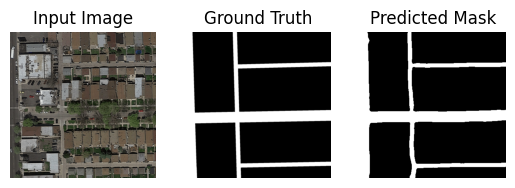

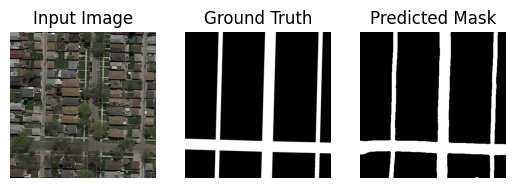

In [11]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
trained_model.eval()

# Iterate over the validation dataset
for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = trained_model(inputs)

    # Convert the predicted output to binary values
    predicted = torch.sigmoid(outputs) > 0.5
    #predicted = outputs

    # Convert tensors to numpy arrays
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Visualize the inputs, ground truth, and predicted masks
    for i in range(inputs.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i].transpose(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()
